In [5]:
# Import some libraries

import socket

from wpgpDownload.utils.dl import wpFtp
from wpgpDownload.utils.isos import Countries

from wpgpDownload.utils.convenience_functions import download_country_covariates

In [6]:
# Get the ISO3 countries codes

import pandas as pd
pd.DataFrame(Countries)


,numeric,alpha3,name
0,643,RUS,Russia
1,360,IDN,Indonesia
2,840,USA,United States
3,850,VIR,Virgin_Islands_U_S
4,304,GRL,Greenland
...,...,...,...
244,882,WSM,Samoa
245,887,YEM,Yemen
246,894,ZMB,Zambia
247,900,KOS,Kosovo


In [125]:
# Search for files

from wpgpDownload.utils.wpcsv import Product
products = Product('BGD')
Results = products.description_contains('people per grid-cell 2020')
for p in Results:
    print('%s/%s\t%s\t%s' % (p.idx, p.country_name,p.dataset_name,p.path))
    

5004/Bangladesh	ppp_2020	GIS\Population\Global_2000_2020\2020\BGD\bgd_ppp_2020.tif
10233/Bangladesh	ppp_2020_UNadj	GIS\Population\Global_2000_2020\2020\BGD\bgd_ppp_2020_UNadj.tif
10481/Bangladesh	ppp_2020_constrained	GIS\Population\Global_2000_2020_Constrained\2020\BSGM\BGD\bgd_ppp_2020_constrained.tif
10722/Bangladesh	ppp_2020_UNadj_constrained	GIS\Population\Global_2000_2020_Constrained\2020\BSGM\BGD\bgd_ppp_2020_UNadj_constrained.tif


In [6]:
Download them with the ISO3 code and id from the terminal

import sys
path = sys.path[0] + '\\grc_ppp_2020.tif'

In [7]:
# import the file
import georasters as gr
file = gr.from_file(path)

<AxesSubplot:>

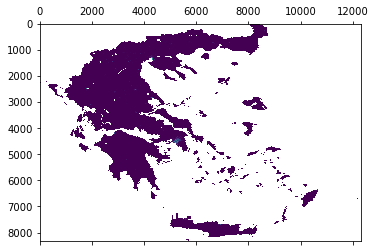

In [8]:
# Plot the file to check if you recognize the countries shape
file.plot()

In [9]:
# Get the city boundaries
import osmnx as ox
import geopandas as gpd
Athens = gpd.GeoDataFrame(ox.geocoder.geocode_to_gdf('Municipality of Athens, Greece'), geometry = 'geometry')

C:\Users\bartb\miniconda3\envs\ssml\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [13]:
# Get the box boundaries of the city with a 50m buffer (100m / 2)
bound = Athens.to_crs(3043).buffer(50, cap_style = 3).to_crs(4326).bounds
bound

,minx,miny,maxx,maxy
0,23.686458,37.948411,23.790985,38.033192


In [11]:
# Get the GeoTIFF to a pandas df
df = file.to_pandas()

In [93]:
from shapely.geometry import Point

# Check if the points are in the box (GeoTIFF in df comes without geometry)
df2 = df[(df['x'] > bound['minx'][0]) & (df['x'] < bound['maxx'][0])
  & (df['y'] > bound['miny'][0]) & (df['y'] < bound['maxy'][0])]
df2 = df2.reset_index()

# Create a point geometry from the x and y
points = []
for i in range(len(df2)):
    points.append(Point(df2['x'][i],df2['y'][i]))
    if (i+1) % 10000000 == 0: print(round((i+1) / len(df2)*100,2), '% done')
df2['point_geom'] = points
df2 = gpd.GeoDataFrame(df2, geometry = 'point_geom', crs = 4326)

# Get a square cell (this is not perfect, but the best we can get)
df2['cell_geom'] = df2.to_crs(3043).buffer(50, cap_style = 3).to_crs(4326)
df2

C:\Users\bartb\miniconda3\envs\ssml\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,index,row,col,value,x,y,point_geom,cell_geom
0,14470763,4458,5178,90.221016,23.687083,38.032917,POINT (23.68708 38.03292),"POLYGON ((23.68774 38.03324, 23.68749 38.03240..."
1,14470764,4458,5179,61.403759,23.687917,38.032917,POINT (23.68792 38.03292),"POLYGON ((23.68857 38.03324, 23.68833 38.03240..."
2,14470765,4458,5180,64.790703,23.688750,38.032917,POINT (23.68875 38.03292),"POLYGON ((23.68941 38.03324, 23.68916 38.03240..."
3,14470766,4458,5181,81.634399,23.689583,38.032917,POINT (23.68958 38.03292),"POLYGON ((23.69024 38.03324, 23.68999 38.03240..."
4,14470767,4458,5182,85.226433,23.690417,38.032917,POINT (23.69042 38.03292),"POLYGON ((23.69107 38.03324, 23.69083 38.03240..."
...,...,...,...,...,...,...,...,...
12744,14794762,4559,5298,4.468120,23.787083,37.948750,POINT (23.78708 37.94875),"POLYGON ((23.78774 37.94907, 23.78749 37.94823..."
12745,14794763,4559,5299,3.152271,23.787917,37.948750,POINT (23.78792 37.94875),"POLYGON ((23.78857 37.94907, 23.78832 37.94823..."
12746,14794764,4559,5300,3.009680,23.788750,37.948750,POINT (23.78875 37.94875),"POLYGON ((23.78941 37.94907, 23.78916 37.94823..."
12747,14794765,4559,5301,2.419969,23.789583,37.948750,POINT (23.78958 37.94875),"POLYGON ((23.79024 37.94907, 23.78999 37.94823..."


In [293]:
# Even with rasterio you won't get box polygons from the GeoTIFF file, you have to create them yourself.
import rasterio
with rasterio.open(path) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    len1 = 0
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):
        len1 = len1 + 1
        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)
        if len1 % 1000 == 0: print(len1)
geom

{'type': 'Polygon',
 'coordinates': [[[19.372083, 41.747917],
   [19.372083, 39.859583],
   [19.372917, 39.859583],
   [19.372917, 39.86125],
   [19.37375, 39.86125],
   [19.37375, 39.862917],
   [19.374583, 39.862917],
   [19.374583, 39.86375],
   [19.375417, 39.86375],
   [19.375417, 39.864583],
   [19.37625, 39.864583],
   [19.37625, 39.86625],
   [19.377917, 39.86625],
   [19.377917, 39.867083],
   [19.37875, 39.867083],
   [19.37875, 39.86875],
   [19.382083, 39.86875],
   [19.382083, 39.869583],
   [19.38375, 39.869583],
   [19.38375, 39.86875],
   [19.387083, 39.86875],
   [19.387083, 39.867917],
   [19.38875, 39.867917],
   [19.38875, 39.867083],
   [19.390417, 39.867083],
   [19.390417, 39.86625],
   [19.392083, 39.86625],
   [19.392083, 39.865417],
   [19.392917, 39.865417],
   [19.392917, 39.864583],
   [19.39375, 39.864583],
   [19.39375, 39.86375],
   [19.394583, 39.86375],
   [19.394583, 39.862917],
   [19.39625, 39.862917],
   [19.39625, 39.862083],
   [19.397917, 39.862

In [106]:
# Check the overlay
geom = gpd.GeoDataFrame(df2, geometry = 'cell_geom', crs = 4326)
Overlayed = geom.overlay(gpd.GeoDataFrame(geometry = Athens['geometry'], crs = 4326))
Overlayed['population'] = round(Overlayed['value']).astype(int)
Overlayed = Overlayed[Overlayed['population'] > 0]
Overlayed = Overlayed[Overlayed.area / Overlayed.area.max() >= 0.99]
popgrid = Overlayed

# Mirror the original popgrid
popgrid = popgrid[['index','population','point_geom','geometry']]
popgrid.columns = ['GRC cell id','population','centroid','grid_geom']
popgrid['centroid_m'] = popgrid['centroid'].to_crs(3043)
popgrid['grid_lon'] = popgrid['centroid_m'].x
popgrid['grid_lat'] = popgrid['centroid_m'].y
popgrid

C:\Users\bartb\AppData\Local\Temp\ipykernel_19148\2046640524.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Overlayed = Overlayed[Overlayed.area / Overlayed.area.max() >= 0.99]
C:\Users\bartb\miniconda3\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\bartb\miniconda3\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,GRC cell id,population,centroid,grid_geom,centroid_m,grid_lon,grid_lat
6,14474159,88,POINT (23.74042 38.03208),"POLYGON ((23.74082 38.03156, 23.73976 38.03176...",POINT (2329228.049 4418523.969),2.329228e+06,4.418524e+06
7,14474160,103,POINT (23.74125 38.03208),"POLYGON ((23.74166 38.03156, 23.74059 38.03176...",POINT (2329302.223 4418541.281),2.329302e+06,4.418541e+06
15,14477475,100,POINT (23.74042 38.03125),"POLYGON ((23.74082 38.03073, 23.73976 38.03093...",POINT (2329249.935 4418430.192),2.329250e+06,4.418430e+06
16,14477476,107,POINT (23.74125 38.03125),"POLYGON ((23.74166 38.03073, 23.74059 38.03093...",POINT (2329324.110 4418447.503),2.329324e+06,4.418448e+06
17,14477477,117,POINT (23.74208 38.03125),"POLYGON ((23.74249 38.03073, 23.74143 38.03093...",POINT (2329398.285 4418464.815),2.329398e+06,4.418465e+06
...,...,...,...,...,...,...,...
5952,14785761,125,POINT (23.72375 37.95125),"POLYGON ((23.72416 37.95073, 23.72309 37.95093...",POINT (2329863.911 4409080.900),2.329864e+06,4.409081e+06
5953,14785762,152,POINT (23.72458 37.95125),"POLYGON ((23.72499 37.95073, 23.72393 37.95093...",POINT (2329938.178 4409098.187),2.329938e+06,4.409098e+06
5958,14788739,139,POINT (23.72208 37.95042),"POLYGON ((23.72249 37.94990, 23.72143 37.95009...",POINT (2329737.204 4408952.537),2.329737e+06,4.408953e+06
5959,14788740,128,POINT (23.72292 37.95042),"POLYGON ((23.72332 37.94990, 23.72226 37.95009...",POINT (2329811.472 4408969.822),2.329811e+06,4.408970e+06


In [266]:
# This will get you the same result as the square buffer. 50m is half the 100m resolution.

from shapely.geometry import Polygon

pp = list(df2['geometry'].to_crs(3043))
Polygons = []
for i in range(len(df2)):
    p = pp[i]
    xmax = p.x+50
    xmin = p.x-50
    ymax = p.y+50
    ymin = p.y-50

    Polygons.append(Polygon([[ymin,xmax],[ymax,xmax],[ymax,xmin],[ymin,xmin]]))
Poly = gpd.GeoDataFrame(geometry = Polygons, crs = 3043)
Poly['index'] = df2.index
Poly = Poly.set_index('index')
df2['cell_geom'] = Poly
df2

,row,col,value,x,y,geometry,cell_geom
14474095,4459,5178,83.470657,23.687083,38.032083,POINT (23.68708 38.03208),POLYGON ((4417367.650499012 2324531.0618426558...
14474096,4459,5179,82.084023,23.687917,38.032083,POINT (23.68792 38.03208),"POLYGON ((4417384.912240449 2324605.231224777,..."
14474097,4459,5180,71.155685,23.688750,38.032083,POINT (23.68875 38.03208),"POLYGON ((4417402.174758998 2324679.400679689,..."
14474098,4459,5181,79.661751,23.689583,38.032083,POINT (23.68958 38.03208),"POLYGON ((4417419.438054671 2324753.570207392,..."
14474099,4459,5182,82.653862,23.690417,38.032083,POINT (23.69042 38.03208),"POLYGON ((4417436.702127477 2324827.739807888,..."
...,...,...,...,...,...,...,...
14791793,4558,5298,3.937485,23.787083,37.949583,POINT (23.78708 37.94958),POLYGON ((4410159.325963783 2335602.2910844474...
14791794,4558,5299,3.242537,23.787917,37.949583,POINT (23.78792 37.94958),POLYGON ((4410176.671830089 2335676.5665646456...
14791795,4558,5300,2.932840,23.788750,37.949583,POINT (23.78875 37.94958),"POLYGON ((4410194.018474593 2335750.842119039,..."
14791796,4558,5301,2.835910,23.789583,37.949583,POINT (23.78958 37.94958),"POLYGON ((4410211.365897311 2335825.117747631,..."


In [205]:
# Write files
Athens.to_file('D:/Dumps/Athens_bound.shp')
gpd.GeoSeries(df2['cell_geom'], crs = 4326).to_file('D:/Dumps/Greece_grids.shp')
df2['geometry'].to_file('D:/Dumps/Greece_points.shp')
gpd.GeoDataFrame(popgrid[['GRC cell id','population','grid_geom']], 
                 geometry = 'grid_geom',crs = 4326).to_file('D:/Dumps/overlayed.shp')

C:\Users\bartb\miniconda3\envs\ssml\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\bartb\AppData\Local\Temp\ipykernel_20852\1070921596.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  Athens.to_file('D:/Dumps/Athens_bound.shp')
